In [34]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from xgboost import XGBClassifier
from tqdm import tqdm
import os
import pickle

## Executive Summary

1. After ignoring the rows for patients with sepsis (as requested), we created a new feature which is the rows count.
2. For each patient we filled the NaN values for our selected features using an linear interpolation method.
3. We calculated the mean of the features after the nulls imputation. This aggregation result represents the patient.
4. For fixing the imbalance of the classes we used over sampling technique.
5. Finally we standardize features by removing the mean and scaling to unit variance.

### The Features

Vital signs:

1. HR - Heart rate (beats per minute)
2. O2Sat - Pulse oximetry (%)
3. Temp - Temperature (Deg C)
4. SBP - Systolic BP (mm Hg)
5. MAP - Mean arterial pressure (mm Hg)
6. DBP - Diastolic BP (mm Hg)
7. Resp - Respiration rate (breaths per minute)
8. EtCO2 - End tidal carbon dioxide (mm Hg)

Laboratory values:

9. BaseExcess - Measure of excess bicarbonate (mmol/L)
10. HCO3 - Bicarbonate (mmol/L)
11. FiO2 - Fraction of inspired oxygen (%)
12. pH - N/A
13. PaCO2 - Partial pressure of carbon dioxide from arterial blood (mm Hg)
14. SaO2 - Oxygen saturation from arterial blood (%)
15. AST - Aspartate transaminase (IU/L)
16. BUN - Blood urea nitrogen (mg/dL)
17. Alkalinephos - Alkaline phosphatase (IU/L)
18. Calcium - amount of calcuim in blood (mg/dL)
19. Chloride (mmol/L)
20. Creatinine (mg/dL)
21. Bilirubin_direct - indicates level of effectiveness in liver's work (mg/dL)
22. Glucose - Serum glucose (mg/dL)
23. Lactate - Lactic acid (mg/dL)
24. Magnesium (mmol/dL)
25. Phosphate (mg/dL)
26. Potassium (mmol/L)
27. Bilirubin_total - Total bilirubin (mg/dL)
28. TroponinI - Troponin I, vital for muscles (ng/mL)
29. Hct - Hematocrit (%)
30. Hgb - Hemoglobin (g/dL)
31. PTT - partial thromboplastin time (seconds)
32. WBC - Leukocyte count (count*10^3/μL)
33. Fibrinogen - level of fibrinogen, which indicates liver’s work (mg/dL)
34. Platelets - level of platelets, which is vital for blooding prevention (count*10^3/μL)

Demographics:

35. Age - age of the patient in years (100 for patients 90 or above)
36. Gender - binary variable, 0 for female and 1 for male
37. Unit1 - Administrative identifier for ICU unit (MICU)
38. Unit2 - Administrative identifier for ICU unit (SICU)
39. HospAdmTime - Hours between hospital admit and ICU admit
40. ICULOS - ICU length-of-stay (hours since ICU admit)

Outcome:

41. SepsisLabel - binary variable. It is 1 if the patient has sepsis or the record is less than 6 hours before the first indication of the sepsis. Otherwise, it is ‘0’.

### Exploring the missing data

In [2]:
def compute_null_prop(mode):
    data = np.array(np.zeros((1, 41)))
    saved = 0
    path = f"/home/student/hw1/data/{mode}"
    
    for psv_file in tqdm(os.listdir(path)):
        
        df = pd.read_csv(f"{path}/{psv_file}", sep='|')
        
        if not saved:
            cols = df.columns
            saved = 1
            
        indices = df[df['SepsisLabel'] == 1].index
        df = df.drop(indices[1:])
        label = 0 if len(indices) == 0 else 1
        
        num_rows = len(df)
        null_counts = df.isna().sum().tolist()
        row = [x/num_rows for x in null_counts]
        data = np.vstack([data, row])
    
    data = np.delete(data, 0, 0)  # Delete the first row
    data = pd.DataFrame(data, columns=cols)
    
    return data.mean()

In [3]:
d = dict(compute_null_prop('train'))
for i, feat in enumerate(d):
    print(f'{i}. {feat}: {round(d[feat], 3)}')

100%|████████████████████████████████████████████████| 20000/20000 [01:14<00:00, 267.21it/s]

0. HR: 0.119
1. O2Sat: 0.151
2. Temp: 0.666
3. SBP: 0.164
4. MAP: 0.146
5. DBP: 0.336
6. Resp: 0.173
7. EtCO2: 0.973
8. BaseExcess: 0.947
9. HCO3: 0.959
10. FiO2: 0.925
11. pH: 0.933
12. PaCO2: 0.947
13. SaO2: 0.966
14. AST: 0.984
15. BUN: 0.932
16. Alkalinephos: 0.984
17. Calcium: 0.943
18. Chloride: 0.955
19. Creatinine: 0.939
20. Bilirubin_direct: 0.998
21. Glucose: 0.831
22. Lactate: 0.975
23. Magnesium: 0.939
24. Phosphate: 0.962
25. Potassium: 0.908
26. Bilirubin_total: 0.985
27. TroponinI: 0.989
28. Hct: 0.911
29. Hgb: 0.926
30. PTT: 0.972
31. WBC: 0.936
32. Fibrinogen: 0.994
33. Platelets: 0.941
34. Age: 0.0
35. Gender: 0.0
36. Unit1: 0.384
37. Unit2: 0.384
38. HospAdmTime: 0.0
39. ICULOS: 0.0
40. SepsisLabel: 0.0


We can see that features 7 to 34 have a high percentage of NaN values. Therefore, we will not use them.

For the other features, we will fill NaN values using an linear interpolation method for each patient.

## Features selection

We will use all features except features 7-34, 'Unit1' and 'Unit2'.

As we saw, features 7-34 were missing approximately 95% of the time.
Also, we thought 'Unit1' and 'Unit2' are not necessary for predicting whether a patient has sepsis.

We added new feature ('Hours') which indicates the number of the dataframe records.

## Preprocessing

In [4]:
def preprocess(mode):
    data = np.array(np.zeros((1, 13)))
    saved = 0
    path = f"/home/student/hw1/data/{mode}"
    
    for psv_file in tqdm(os.listdir(path)):
        df = pd.read_csv(f"{path}/{psv_file}", sep='|')
        
        # Drop columns
        df = df.drop(columns=df.iloc[:, 7:34].columns, axis=1)
        df = df.drop(['Unit1', 'Unit2'], axis=1)
        
        if not saved:
            cols = df.columns.tolist()
            saved = 1
            
        # If 'SepsisLabel' == 1 -> ignore rows
        indices = df[df['SepsisLabel'] == 1].index
        df = df.drop(indices[1:])  
        label = 0 if len(indices) == 0 else 1
        
        # New feature
        hours = len(df)
        
        # Fill nulls
        df = df.interpolate(method='linear', limit_direction='both', axis=1)
        
        # Calculate mean values (labels column not included)
        row = df.iloc[:, :-1].mean().to_numpy() 
        
        row = np.append(row, [hours, label])
        data = np.vstack([data, row])
    
    data = np.delete(data, 0, 0)  # Delete the first row
    
    cols.insert(11, 'Hours')
    
    data = pd.DataFrame(data, columns=cols)
    
    return data

In [5]:
train_set = preprocess('train')

100%|████████████████████████████████████████████████| 20000/20000 [01:56<00:00, 172.18it/s]


In [6]:
X_train_pre = train_set.iloc[:, :-1]
y_train_pre = train_set.iloc[:, -1]
features = X_train_pre.columns.tolist()

The train data consists of 20,000 patients. Each patient has records related to the amount of hours he was at the hospital.

In [7]:
train_set["SepsisLabel"].value_counts()

0.0    18585
1.0     1415
Name: SepsisLabel, dtype: int64

<AxesSubplot: ylabel='Sepsis'>

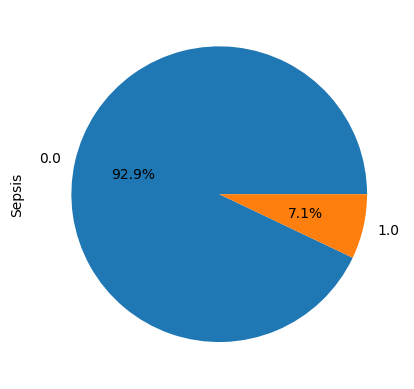

In [8]:
train_set.groupby('SepsisLabel').size().plot(kind='pie', label="Sepsis", y="SepsisLabel", autopct='%1.1f%%')

We can see the data is imbalanced: only 7.1% of the patients labeled as sick.

### Data enrichment - over sampling

Due to the imbalance, we dicided to enrich the amount of observations from the minority class. We used synthetic minority oversampling technique for nominal and continuous (SMOTENC). 

Instead of randomly oversampling with replacement, SMOTE takes each minority sample and introduces synthetic data points connecting the minority sample and its nearest neighbors. Neighbors from the k-nearest neighbors are chosen randomly.

In [9]:
X_train_smote, y_train_smote = SMOTENC(categorical_features=[8], random_state=42).fit_resample(X_train_pre, y_train_pre)

y_train_smote.value_counts()

0.0    18585
1.0    18585
Name: SepsisLabel, dtype: int64

The minority category increased from 1,415 to 18,585 after SMOTENC oversampling.

### Data normalization

Standardize features by removing the mean and scaling to unit variance.

In [10]:
scaler = StandardScaler().fit(X_train_smote)
X_train_scaled = scaler.transform(X_train_smote)

In [11]:
# save scaler model for predict.py
# pickle.dump(scaler, open('scaler.sav', 'wb'))

## Prediction

Loading and preprocessing the test data.

In [12]:
test_set = preprocess('test')

100%|████████████████████████████████████████████████| 10000/10000 [00:59<00:00, 167.01it/s]


In [13]:
X_test = test_set.iloc[:, :-1]
y_test = test_set.iloc[:, -1]

# Normalization
X_test_scaled = scaler.transform(X_test)

In [14]:
preds = {}  # for saving test predictions

#### Split the data to train and validation sets

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_scaled, y_train_smote, test_size=0.2, random_state=42)

For each algorithm we perform 3-fold cross validation to find the best hyperparameters (including parameters for regularization) over specified values.

### 1. Support Vector Machine (SVM)

First, we used SVM to see the performance of a linear model on our data.

The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space (N is the number of features) that distinctly classifies the data points.

#### Cross validation & hyperparameter tuning

In [16]:
# # Create the parameter grid 
# svm_params = {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 0.01, 0.1]}

# # Create a based model
# sv = SVC()

# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator=sv, param_grid=svm_params, scoring='f1', cv=3, verbose=1)
# grid_result = grid_search.fit(X_train, y_train)

# print("Best parameter after tuning: %s" % (grid_result.best_params_))

Best parameter after tuning: {`C`: `100`, `gamma`: `scale`}

#### Training and validation results

In [17]:
# chosen_svc = grid_result.best_estimator_
# chosen_svc = SVC(C=100, gamma='scale')
chosen_svc = SVC(C=10, gamma=0.01)  # better on test
trained_svc = chosen_svc.fit(X_train, y_train)

In [18]:
valid_pred_svc = trained_svc.predict(X_valid)

print(f'Precision: {precision_score(y_valid, valid_pred_svc)}')
print(f'Recall: {recall_score(y_valid, valid_pred_svc)}')
print(f'f1 score: {f1_score(y_valid, valid_pred_svc)}')

Precision: 0.9198418404025881
Recall: 0.6946254071661238
f1 score: 0.7915248994741725


#### Test results

In [19]:
test_pred_svc = trained_svc.predict(X_test_scaled)
preds['SVM'] = test_pred_svc

print(f'Precision: {precision_score(y_test, test_pred_svc)}')
print(f'Recall: {recall_score(y_test, test_pred_svc)}')
print(f'f1 score: {f1_score(y_test, test_pred_svc)}')

Precision: 0.48050682261208577
Recall: 0.6653171390013495
f1 score: 0.5580079230333899


### 2. Random Forest

One of the strongest ML models that exists. It combines the power of bagging, feature selection and trees to one powerful model.

#### Cross validation & hyperparameter tuning

In [20]:
# rf_params = {'n_estimators': [100, 500, 1000], 'min_samples_leaf': [1, 3, 5], 'min_samples_split': [2, 5, 10]}
    
# rf = RandomForestClassifier()
# grid_search = GridSearchCV(estimator=rf, param_grid=rf_params, scoring='f1', cv=3, verbose=1)
# grid_result = grid_search.fit(X_train, y_train)

# print("Best parameter after tuning: %s" % (grid_result.best_params_))

Best parameter after tuning: {`min_samples_leaf`: `1`, `min_samples_split`: `2`, `n_estimators`: `1000`}

#### Training and validation results

In [21]:
# chosen_rf = random_result.best_estimator_
# chosen_rf = RandomForestClassifier(n_estimators=1000, min_samples_split=2, min_samples_leaf=1, random_state=42)
chosen_rf = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1, random_state=42)  # better on test
trained_rf = chosen_rf.fit(X_train, y_train)

In [22]:
valid_pred_rf = trained_rf.predict(X_valid)

print(f'Precision: {precision_score(y_valid, valid_pred_rf)}')
print(f'Recall: {recall_score(y_valid, valid_pred_rf)}')
print(f'f1 score: {f1_score(y_valid, valid_pred_rf)}')

Precision: 0.9753462603878116
Recall: 0.9557546145494028
f1 score: 0.965451055662188


#### Test results

In [23]:
test_pred_rf = trained_rf.predict(X_test_scaled)
preds['Random Forest'] = test_pred_rf

print(f'Precision: {precision_score(y_test, test_pred_rf)}')
print(f'Recall: {recall_score(y_test, test_pred_rf)}')
print(f'f1 score: {f1_score(y_test, test_pred_rf)}')

Precision: 0.6871428571428572
Recall: 0.6491228070175439
f1 score: 0.6675919500346982


#### Features importances

In [24]:
l = []
for i, feature in enumerate(features):
    l.append((feature, trained_rf.feature_importances_[i]))
l.sort(key=lambda x: x[1], reverse=True)  
for feature, importance in l:
    print(feature, importance)

Hours 0.268345574152062
ICULOS 0.2394349894026137
HospAdmTime 0.08197878572052736
HR 0.05830070913280729
SBP 0.058045631109446126
Resp 0.05280377571587369
O2Sat 0.04977590732455107
Temp 0.04852752025174101
Age 0.04567068927388072
DBP 0.04437753905775792
MAP 0.04326317913256172
Gender 0.009475699726177374


### 3. Gradient Boosted Trees (XGboost)

XGboost is an ensemble learning method that combines multiple decision trees to make a more robust and accurate prediction.

#### Cross validation & hyperparameter tuning

In [25]:
# xgb_params = {"n_estimators": [100, 500, 1000], "max_depth": [3, 6, 9], "learning_rate": [0.01, 0.1, 0.3]}
    
# xgb = XGBClassifier()

# grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_params, scoring='f1', cv=3, verbose=1)
# grid_result = grid_search.fit(X_train, y_train)

# print("Best parameter after tuning: %s" % (grid_result.best_params_))

Best parameter after tuning: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500}

#### Training and validation results

In [26]:
# chosen_xgb = grid_result.best_estimator_
chosen_xgb = XGBClassifier(n_estimators=500, max_depth=6, learning_rate=0.1)
trained_xgb = chosen_xgb.fit(X_train, y_train)

In [27]:
valid_pred_xgb = trained_xgb.predict(X_valid)

print(f'Precision: {precision_score(y_valid, valid_pred_xgb)}')
print(f'Recall: {recall_score(y_valid, valid_pred_xgb)}')
print(f'f1 score: {f1_score(y_valid, valid_pred_xgb)}')

Precision: 0.9887486278814489
Recall: 0.9780130293159609
f1 score: 0.9833515283842795


#### Test results

In [28]:
test_pred_xgb = trained_xgb.predict(X_test_scaled)
preds['XGboost'] = test_pred_xgb

print(f'Precision: {precision_score(y_test, test_pred_xgb)}')
print(f'Recall: {recall_score(y_test, test_pred_xgb)}')
print(f'f1 score: {f1_score(y_test, test_pred_xgb)}')

Precision: 0.822141560798548
Recall: 0.611336032388664
f1 score: 0.7012383900928791


#### Features importances

In [29]:
l = []
for i, feature in enumerate(features):
    l.append((feature, trained_xgb.feature_importances_[i]))
l.sort(key=lambda x: x[1], reverse=True)  
for feature, importance in l:
    print(feature, importance)

Hours 0.36954823
ICULOS 0.15206762
Gender 0.10866195
HospAdmTime 0.08602886
HR 0.049112473
O2Sat 0.038754784
SBP 0.034732375
Age 0.034548957
Resp 0.034388322
Temp 0.03224411
MAP 0.030711895
DBP 0.029200371


We can see that 'Hours' is the most informative feature for the classification.

In [30]:
# save model
# pickle.dump(trained_xgb, open('xgb.sav', 'wb'))

## Post Analysis

### Test results summary

In [31]:
results = {'model': [], 'precision': [], 'recall': [], 'f1': []}

for model in preds.keys():
    results['model'].append(model)
    results['precision'].append(precision_score(y_test, preds[model]))
    results['recall'].append(recall_score(y_test, preds[model]))
    results['f1'].append(f1_score(y_test, preds[model]))
    
results = pd.DataFrame(results)
results

,model,precision,recall,f1
0,SVM,0.480507,0.665317,0.558008
1,Random Forest,0.687143,0.649123,0.667592
2,XGboost,0.822142,0.611336,0.701238


### ROC-AUC Curve

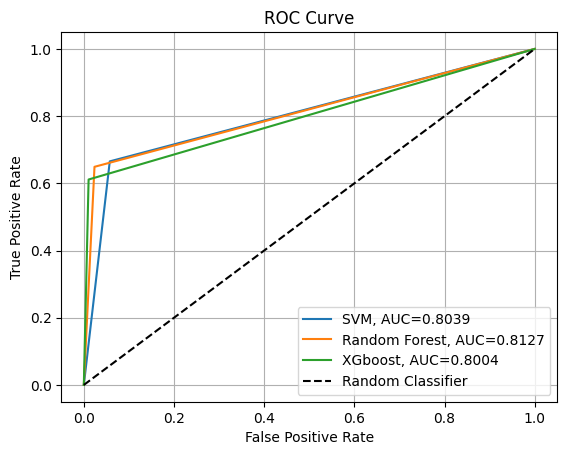

In [32]:
plt.figure().clf()

# SVM
fpr, tpr, _ = roc_curve(y_test, preds['SVM'])
auc = round(roc_auc_score(y_test, preds['SVM']), 4)
plt.plot(fpr, tpr, label="SVM, AUC=" + str(auc))

# Random Forest
fpr, tpr, _ = roc_curve(y_test, preds['Random Forest'])
auc = round(roc_auc_score(y_test, preds['Random Forest']), 4)
plt.plot(fpr, tpr, label="Random Forest, AUC=" + str(auc))

# XGboost
fpr, tpr, _ = roc_curve(y_test, preds['XGboost'])
auc = round(roc_auc_score(y_test, preds['XGboost']), 4)
plt.plot(fpr, tpr, label="XGboost, AUC=" + str(auc))

plt.plot([0, 1], ls="--", label='Random Classifier', c='black')
plt.legend()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.show()

The AUROC is relatively similar for all the models, but XGboost got the best result.

## Summary and discussion

The task was interesting and challenging.

Some conclusions:
1. There is high importance for data representation and features selection. 
2. Applying a up-sampling method to treat the imbalanced data improved the results.